In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.conv_learner import *
PATH = os.path.expanduser('~/data/planet/')

In [23]:
!ls {PATH}

sample_submission_v2.csv  test-jpg-additional	    train-jpg
test-jpg		  test_v2_file_mapping.csv  train_v2.csv


In [73]:
from planet import f2

metrics=[f2] # imposed by https://www.kaggle.com/c/planet-understanding-the-amazon-from-space
f_model = resnet34

label_csv = os.path.join(PATH, 'train_v2.csv')
with open(label_csv) as f:
    n = len(f.readlines()) - 1
val_idxs = get_cv_idxs(n)

In [47]:
def get_data(sz, f_model):
    tfms = tfms_from_model(
        f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(
        PATH,
        os.path.join(PATH, 'train-jpg'),
        label_csv,
        tfms=tfms,
        suffix=".jpg",
        val_idxs=val_idxs,
        test_name=os.path.join(PATH, "test-jpg"))

In [48]:
data = get_data(256, f_model) # for initial look, pick smaller size later

In [49]:
x, y = next(iter(data.val_dl))

In [50]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [51]:
list(c for (c, v) in zip(data.classes, y[0]) if v)

['agriculture', 'clear', 'primary', 'water']

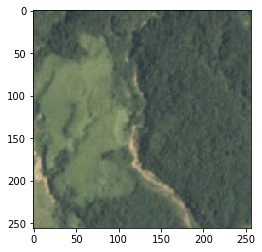

In [61]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.3);

In [66]:
sz = 64
data = get_data(sz, f_model)

The training/test time augmentation happens on the full images with resizing to `sz` by `sz` pixels as the last step (see a bit before 1:40:59).  Depending on the original image size, this can be slow.  `data.resize` does one pass over the data, generating resized images so that they load and transform faster.  The result is cached.  This step is not mandatory, but speeds up the process.

In [67]:
data = data.resize(round(sz * 1.3), 'tmp')

In [68]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
learn.lr_find()

epoch      trn_loss   val_loss   f2                          
    0      0.214263   0.225128   0.838253  



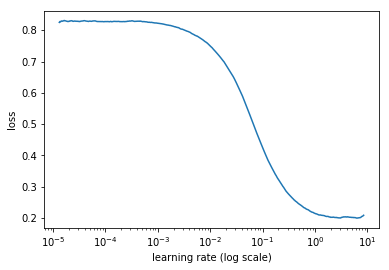

In [69]:
learn.sched.plot()

A first `learn.fit(0.2, 3, cycle_len=1)` didn't do a lot, so I reloaded and 
increased the training effort:

In [70]:
learn.fit(0.2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.147403   0.133648   0.880974  
    1      0.138244   0.126874   0.88909                     
    2      0.135886   0.124994   0.89071                     
    3      0.133787   0.123968   0.892438                    
    4      0.13231    0.121876   0.894191                    
    5      0.127392   0.120799   0.894464                    
    6      0.128201   0.12054    0.894426                    



[array([0.12054]), 0.8944255815740767]

In [72]:
learn.unfreeze()
learn.fit([0.2/9, 0.2/3, 0.2], 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.116034   0.104531   0.913034  
    1      0.112477   0.10038    0.916587                    
    2      0.101176   0.097865   0.918133                     
    3      0.106641   0.100861   0.914593                    
    4      0.101858   0.096577   0.918303                     
    5      0.094528   0.094795   0.920584                     
    6      0.087263   0.094798   0.921136                     



[array([0.0948]), 0.9211356768519765]

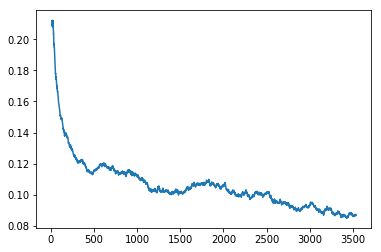

In [74]:
learn.sched.plot_loss()

In [75]:
learn.save("sz64")

epoch      trn_loss   val_loss   f2                           
    0      0.129325   0.163873   0.891292  



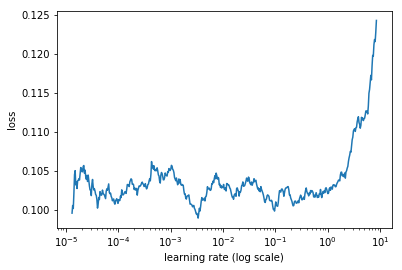

In [77]:
sz = 128
data = get_data(sz, f_model)
learn.set_data(data) # this also re-freezes the model
learn.freeze() # just to be sure, because the `official' notebook does it
learn.lr_find()
learn.sched.plot()

It doesn't look like I can do much better, training again out of curiosity.

In [78]:
learn.fit(0.2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.096863   0.095725   0.918543  
    1      0.097931   0.094481   0.919787                     
    2      0.093856   0.093777   0.920193                     
    3      0.096008   0.094771   0.918877                     
    4      0.090026   0.092792   0.921635                     
    5      0.09185    0.092406   0.921804                     
    6      0.092038   0.092279   0.922307                     



[array([0.09228]), 0.9223066333409908]

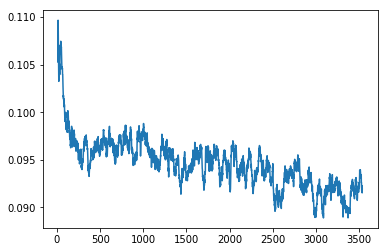

In [79]:
learn.sched.plot_loss()

In [80]:
learn.save("sz128")